Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               

                                )]                                                                

                                                                                                  

 sequential (Sequential)        (None, 4096)         21557952    ['input_3[0][0]']                

                                                                                                  

 densenet201 (Functional)       (None, 1920)         18315712    ['input_3[0][0]']                

                                                                                                  

 ResNet50 (Functional)          (None, 2048)         23581440    ['input_3[0][0]'] 

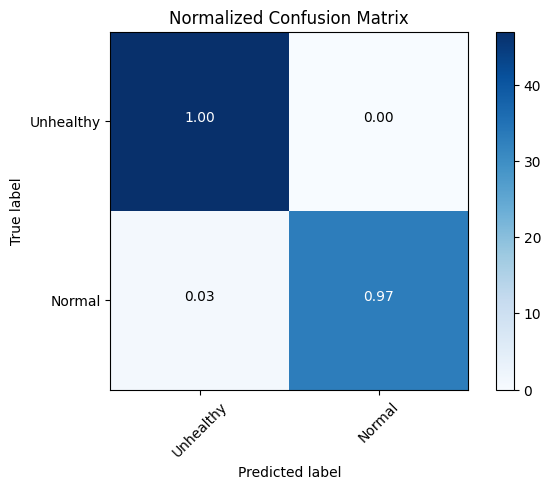

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,classification_report
import itertools
from sklearn.model_selection import cross_val_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_shape = 224

####################################################################################

model = load_model('/home/syasun/hybrid/ensemble_model_1024_features_vector.h5')
model.summary()
image_path = '/home/syasun/CXR_png/'

####################################################################################
def load_images_from_folder(folder):
    images = []
    labels = []
    count_0 = 0
    count_1 = 0
    
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(224, 224), color_mode="grayscale")
        img_array = img_to_array(img)
        
        #label = 1 if "_1." in filename else 0
        label = 1 if "_1." in filename else 0

        if label == 0:
            count_0 += 1
        else:
            count_1 += 1

        images.append(img_array)
        labels.append(label)

    print(f"Toplam 0 etiketli resim sayısı: {count_0}")
    print(f"Toplam 1 etiketli resim sayısı: {count_1}")

    return images, labels

folder_A = '/home/syasun/CXR_png'
images_train_A, labels_train_A = load_images_from_folder(folder_A)

####################################################################################
random_state = int(time.time())

X_train, X_test, y_train, y_test = train_test_split(np.array(images_train_A), np.array(labels_train_A), test_size=0.20,random_state=random_state)

print("X train shape",X_train.shape)
print("y train shape",y_train.shape)

print("X test shape",X_test.shape)
print("y test shape",y_test.shape)

print(y_train)
print(y_test)

from sklearn.linear_model import LogisticRegression

ensemble_features_train = model.predict(X_train)
ensemble_features_test = model.predict(X_test)

flattened_ensemble_features_train = ensemble_features_train.reshape(ensemble_features_train.shape[0], -1)
flattened_ensemble_features_test = ensemble_features_test.reshape(ensemble_features_test.shape[0], -1)

logistic_regression = LogisticRegression(max_iter=10000)

param_grid = {
    'C': [0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2'],   
    'solver': ['liblinear', 'saga'] 
}

grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5)
grid_search.fit(flattened_ensemble_features_train, y_train)

best_logistic_regression = LogisticRegression(**grid_search.best_params_, max_iter=10000)
best_logistic_regression.fit(flattened_ensemble_features_train, y_train)

y_pred = best_logistic_regression.predict(flattened_ensemble_features_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Test Doğruluğu: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j] if normalize else cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = ['Unhealthy', 'Normal']
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc_score = roc_auc_score(y_test, y_pred, average='weighted')
#auc_score = auc(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {auc_score:.2f}')